## Setup

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers

%config InlineBackend.figure_format = 'retina'

In [2]:
data = '../datasets/autoria/autoria_data.csv'
clean_data = '../datasets/autoria/autoria_clean_data.csv'

mape = {
    'Linear regression': 77,
    'SVMs': 74,
    'Decision Tree': 18,
    'K-Nearest Neighbor': 17,
    'Random Forest': 17,
    'XGBoost Regression': 16
}

# Car price predictor


**Goals**
- Predict car price given its image
- Improve predictions adding more iformation about the car


## Data collection

**Data source:** 
<br>
https://auto.ria.com/uk/

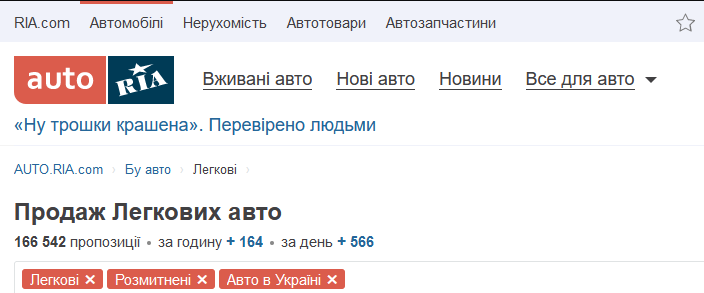

**Page layout**

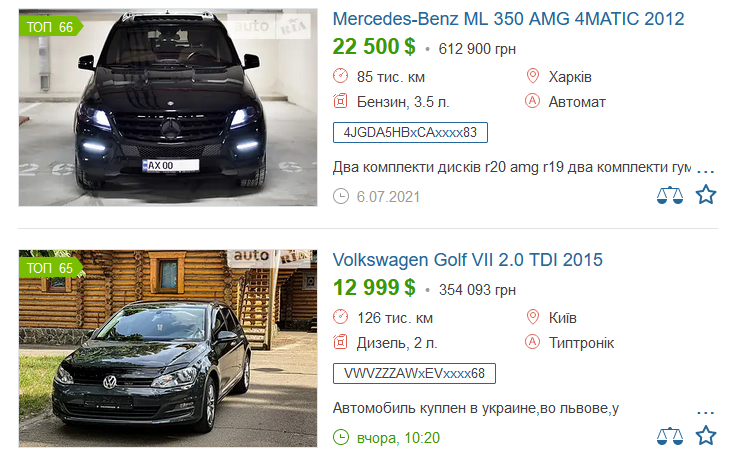

**Scraping outcome**

Pages scraped - 15 511
<br>
Cars loaded - 146 814
<br>
<br>
Empty pages - 14
<br>
Blank images - 337

## Data cleaning

### Tabular data cleaning

In [3]:
pd.read_csv(data, sep='|', index_col='id', encoding='cp1251').head()

brand  price currency        mileage  \
id                                                                              
0   Mercedes-Benz E 280 4MATIC AT CLASSIC 2007   8999      USD   159 тис. км    
1             Mercedes-Benz G 350 Designo 2015  79900      USD   103 тис. км    
2                                BMW 550  2010  15999      USD   145 тис. км    
3                       MINI Countryman S 2014  10200      USD   111 тис. км    
4                         Nissan X-Trail  2010  13900      USD    97 тис. км    

               fuel_type transmission_type                        pub_date  
id                                                                          
0    Газ / Бензин, 3 л.           Автомат             21.05.2021            
1          Дизель, 3 л.           Автомат             15.05.2021            
2        Бензин, 4.4 л.           Автомат             18.04.2021            
3        Бензин, 1.6 л.           Автомат      сьогодні о 12:00             
4          Бензин, 2 л.           Автомат             19.05.2021

In [4]:
pd.read_csv(clean_data, index_col='id').head()

brand  price_USD  mileage_kkm   fuel_type transmission_type  \
id                                                                        
0   Mercedes-Benz       8999          159  gas/petrol         automatic   
1   Mercedes-Benz      79900          103      diesel         automatic   
2             BMW      15999          145      petrol         automatic   
3            MINI      10200          111      petrol         automatic   
4          Nissan      13900           97      petrol         automatic   

      pub_date  year_made                    model  engine_size  
id                                                               
0   2021-05-21       2007  E 280 4MATIC AT CLASSIC          3.0  
1   2021-05-15       2015            G 350 Designo          3.0  
2   2021-04-18       2010                      550          4.4  
3   2021-05-21       2014             Countryman S          1.6  
4   2021-05-19       2010                  X-Trail          2.0

### Images cleaning

Some users used interior of a car as a primary image but we need exterior

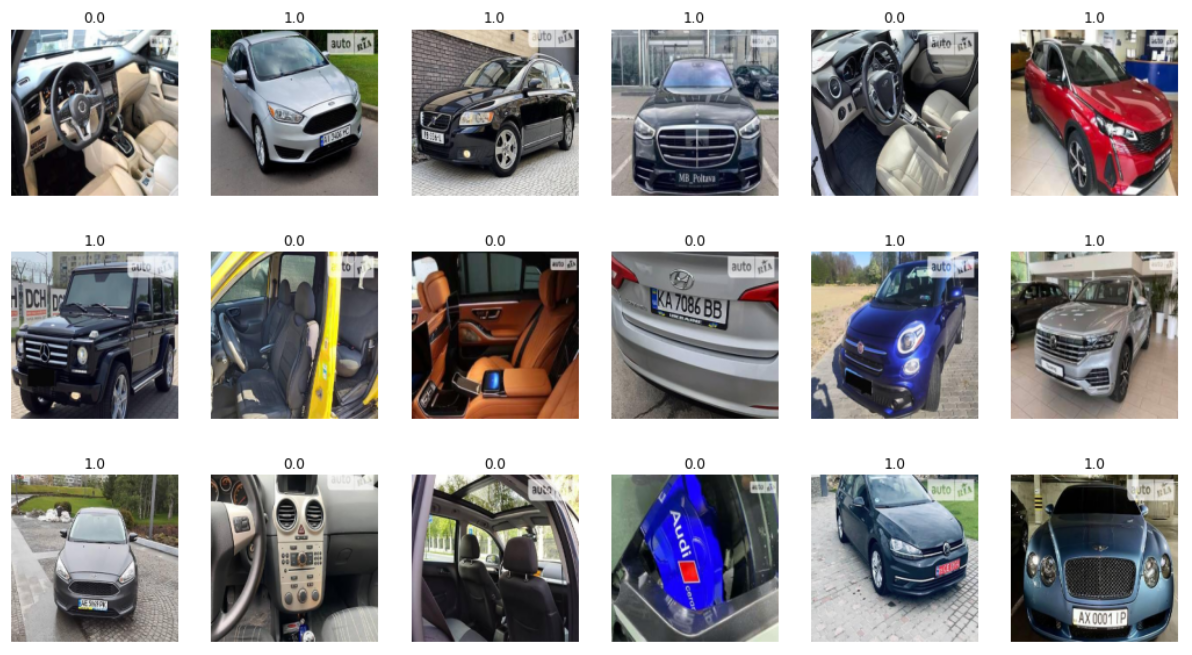

64 car
<br>
64 not car images

In [5]:
input_shape = (224, 224, 3)

conv_base = keras.applications.vgg16.VGG16(include_top=False,
                                           input_shape=input_shape)
conv_base.trainable = False

data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.05),
    layers.experimental.preprocessing.RandomZoom(0.2)
])

inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

#### Model summary

In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129   

#### .

3 epochs -> validation accuracy: 96.15 %

Predictions on validation set

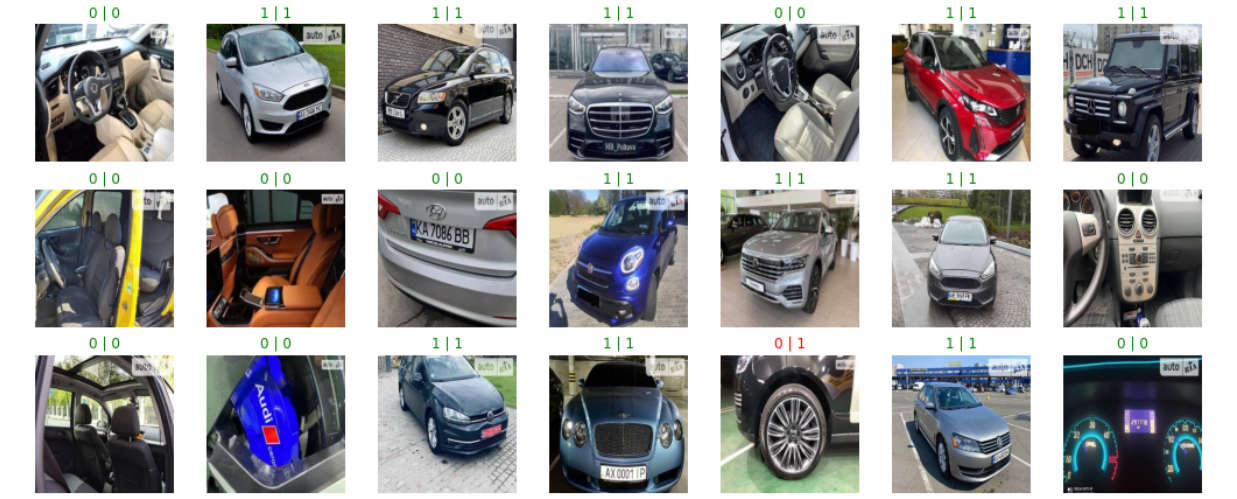

**6126** images classified as not cars 

Non car images

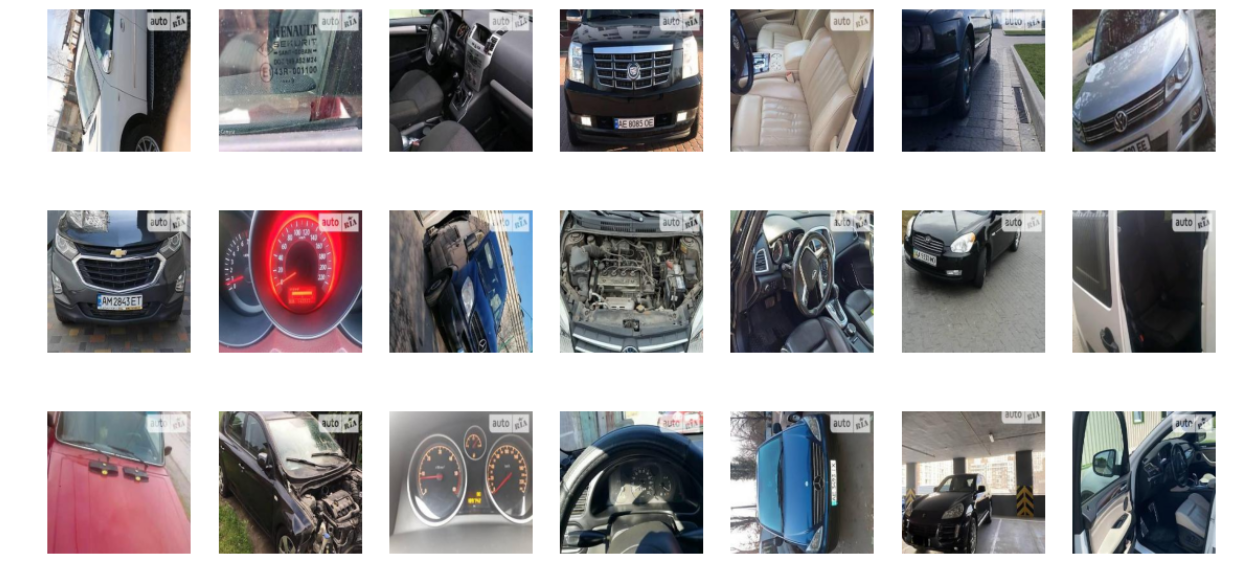

## Exploratory data analysis

https://github.com/MorhaliukOL/ML_Project/blob/main/analysis/autoria_EDA.ipynb

## Model training

**Baseline** - one parameter model (return **median** for all inputs)

**mape - 74%**

### Tabular

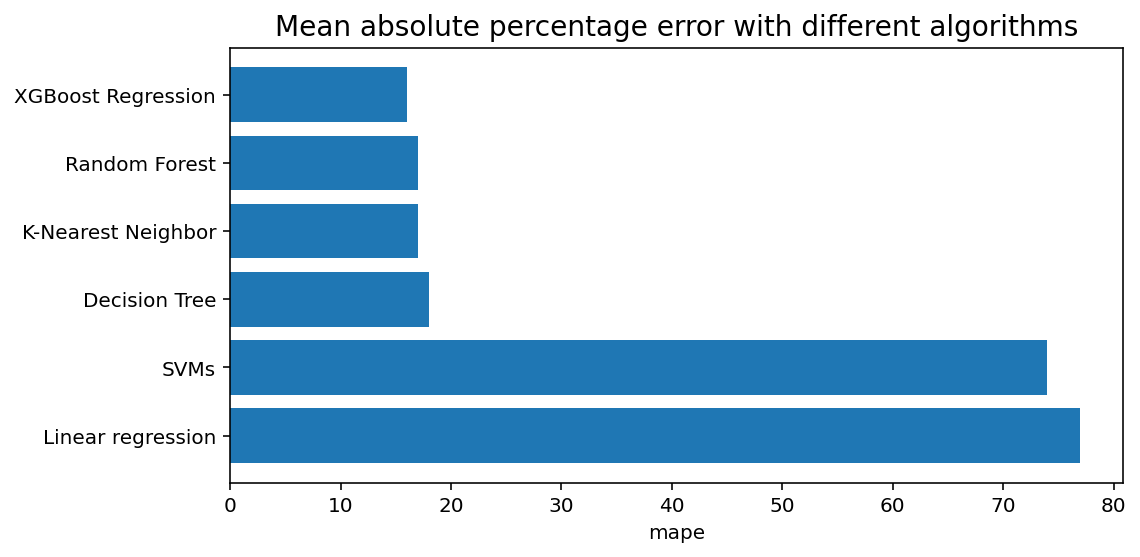

In [8]:
plt.figure(figsize=(8, 4))
plt.barh(list(mape.keys()), list(mape.values()))
plt.xlabel('mape')
plt.title('Mean absolute percentage error with different algorithms', fontsize=14)
plt.show()

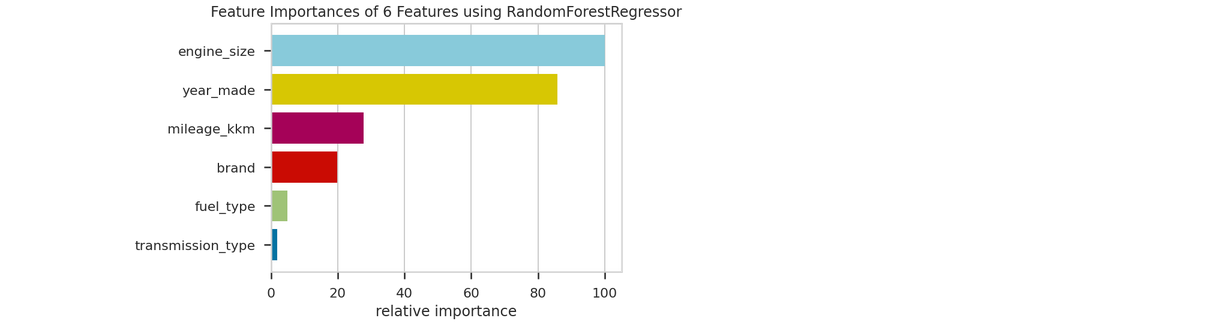

### Images

#### From scratch model

In [ ]:
model = keras.Sequential([
    layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)),

    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3)),

    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),

    layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),

    layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)),

    layers.Flatten(),
    layers.Dense(1024,activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(1024,activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(10,activation='relu'),
    layers.Dense(1,activation='relu'),
])

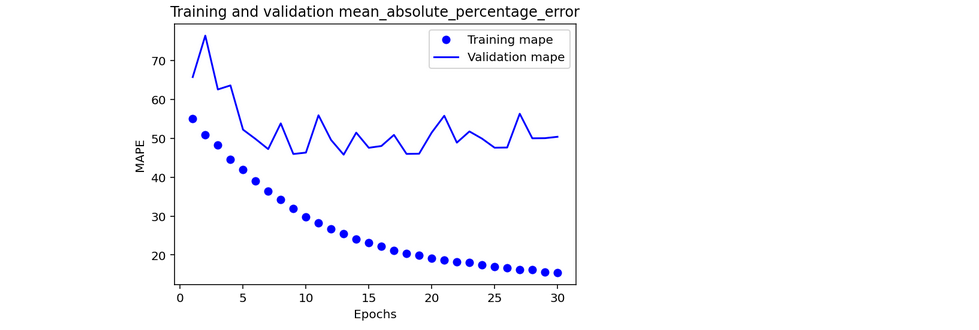

#### Pretrained model

In [9]:
model = keras.models.load_model('../train/models/vgg16_based_192_mape_price_lim_30k')

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 19,433,793
Trainable params: 19,433,793
Non-trainable params: 0
_________________________________________________________________


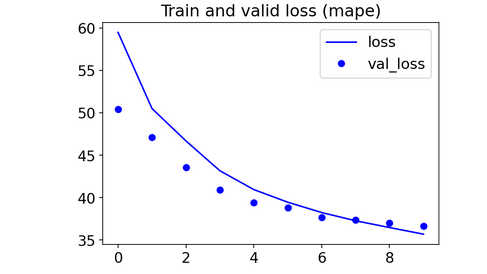

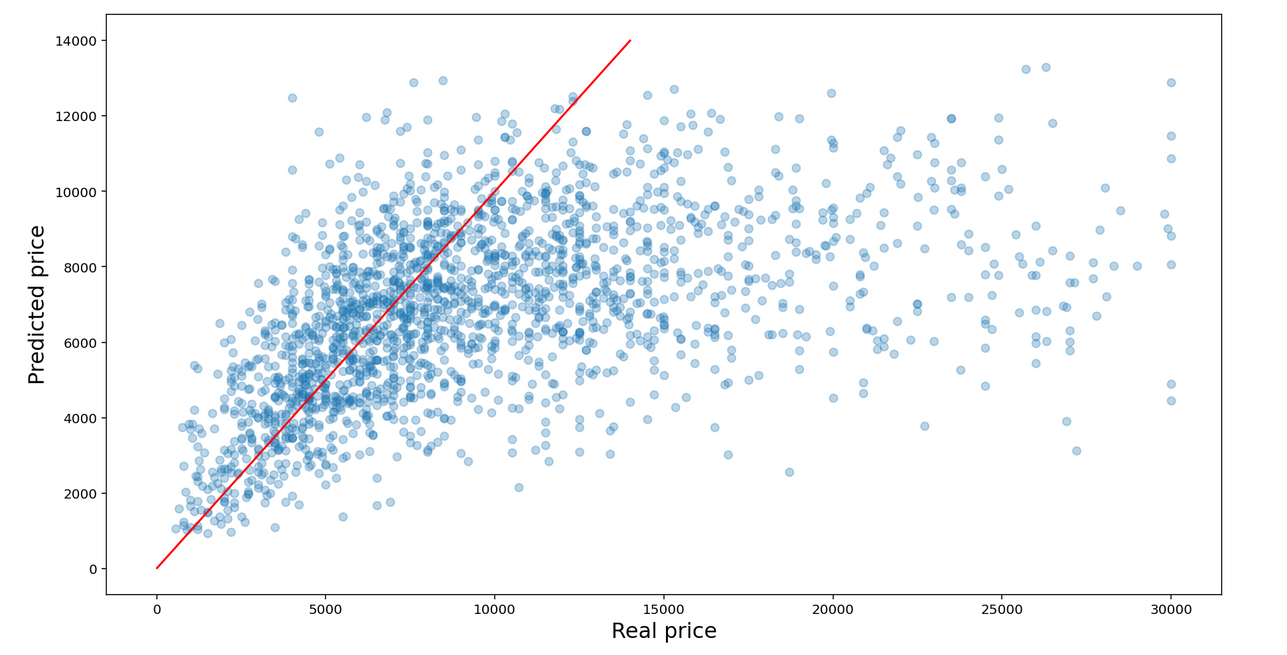

Model predictions
<br><br>
**true price | predicted price**

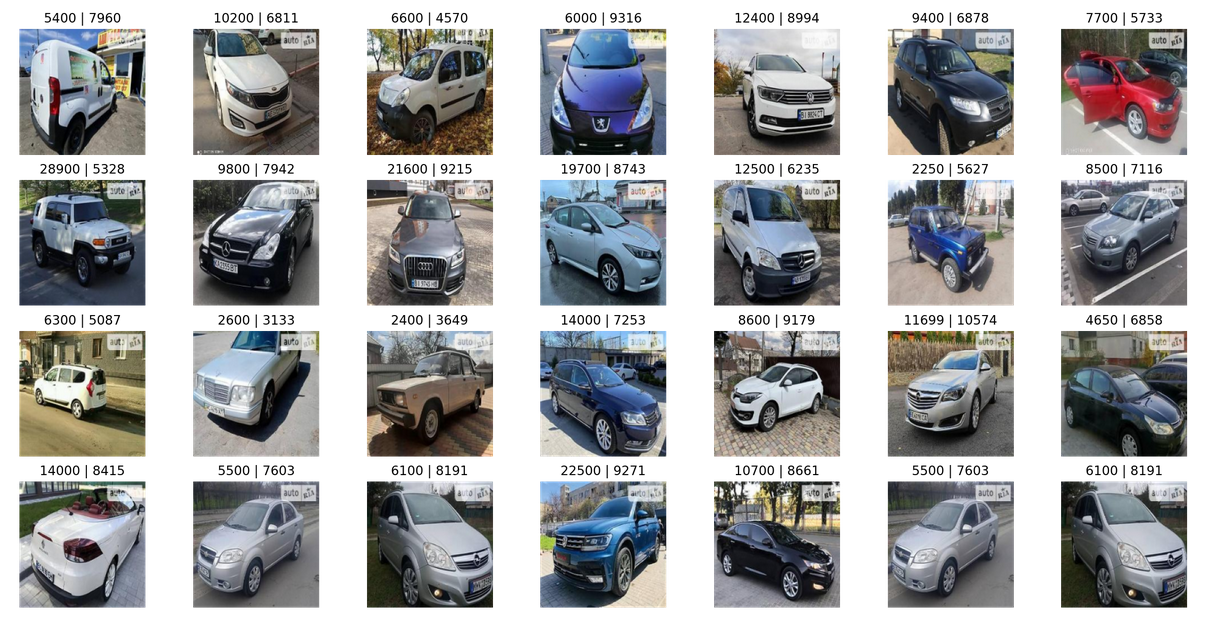